# The Parcels Kernel loop


This tutorial explains how Parcels executes multiple Kernels, and what happens under the hood when you combine Kernels. 

This is probably not very relevant when you only use the built-in Advection kernels, but can be important when you are writing and combining your own Kernels!

## Background

When you run a Parcels simulation (i.e. a call to `pset.execute()`), the Kernel loop is the main part of the code that is executed. This part of the code loops through all particles and executes the Kernels that are defined for each particle.

In order to make sure that the displacements of a particle in the different Kernels can be summed, all Kernels add to a _change_ in position (`particles.dlon`, `particles.dlat`, and `particles.dz`). This is important, because there are situations where movement kernels would otherwise not commute. Take the example of advecting particles by currents _and_ winds. If the particle would first be moved by the currents and then by the winds, the result could be different from first moving by the winds and then by the currents. Instead, by adding the changes in position, the ordering of the Kernels has no consequence on the particle displacement.

## Basic implementation

Below is a structured overview of the Kernel loop is implemented. Note that this is for `lon` only, but the same process is applied for `lat` and `z`.

1. Initialise an extra Variable `particles.dlon=0`

2. Within the Kernel loop, for each particle:<br>

    1. Update `particles.lon += particles.dlon`<br>

    2. Update `particles.time += particles.dt` (except for on the first iteration of the Kernel loop)<br>

    3. Set variable `particles.dlon = 0`<br>

    4. For each Kernel in the list of Kernels:
        
        1. Execute the Kernel
        
        2. Update `particles.dlon` by adding the change in longitude, if needed<br>

    5. If `outputdt` is a multiple of `particle.time`, write `particle.lon` and `particle.time` to zarr output file<br>

Besides having commutable Kernels, the main advantage of this implementation is that, when using Field Sampling with e.g. `particle.temp = fieldset.Temp[particle.time, particle.z, particle.lat, particle.lon]`, the particle location stays the same throughout the entire Kernel loop. Additionally, this implementation ensures that the particle location is the same as the location of the sampled field in the output file.

## Example use

Below is a simple example of some particles at the surface of the ocean. We create an idealised zonal wind flow that will "push" a particle that is already affected by the surface currents.

In [1]:
from datetime import timedelta

import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

import parcels

/var/folders/fd/p7j_05zx409dzmtfjjjnjgfh0000gn/T/ipykernel_19079/1981051754.py:7: UserWarning: This is an alpha version of Parcels v4. The API is not stable and may change without deprecation warnings.
  import parcels


In [2]:
# Load the CopernicusMarine data in the Agulhas region from the example_datasets
example_dataset_folder = parcels.download_example_dataset(
    "CopernicusMarine_data_for_Argo_tutorial"
)

ds_fields = xr.open_mfdataset(f"{example_dataset_folder}/*.nc", combine="by_coords")
ds_fields.load()  # load the dataset into memory

# Create an idealised wind field and add it to the fieldset
tdim, ydim, xdim = (len(ds_fields.time),len(ds_fields.latitude), len(ds_fields.longitude))
ds_fields["UWind"] = xr.DataArray(
    data=np.ones((tdim, ydim, xdim)) * np.sin(ds_fields.latitude.values)[None, :, None],
    coords=[ds_fields.time, ds_fields.latitude, ds_fields.longitude])

ds_fields["VWind"] = xr.DataArray(
    data=np.zeros((tdim, ydim, xdim)),
    coords=[ds_fields.time, ds_fields.latitude, ds_fields.longitude])

fieldset = parcels.FieldSet.from_copernicusmarine(ds_fields)

fieldset.UWind.units = parcels.GeographicPolar()
fieldset.VWind.units = parcels.Geographic()

INFO: cf_xarray found variable 'uo' with CF standard name 'eastward_sea_water_velocity' in dataset, renamed it to 'U' for Parcels simulation.
INFO: cf_xarray found variable 'vo' with CF standard name 'northward_sea_water_velocity' in dataset, renamed it to 'V' for Parcels simulation.


Now define a wind kernel that uses a forward Euler method to apply the wind forcing. Note that we update the `particle_dlon` and `particle_dlat` variables, rather than `particle.lon` and `particle.lat` directly.

In [3]:
def wind_kernel(particles, fieldset):
    dt_float = particles.dt / np.timedelta64(1, 's')
    particles.dlon += (
        fieldset.UWind[particles] * dt_float
    )
    particles.dlat += (
        fieldset.VWind[particles] * dt_float
    )

Run a simulation where we apply first kernels as `[AdvectionRK4, wind_kernel]`

In [4]:
npart = 10
z = np.repeat(ds_fields.depth[0].values, npart)
lons = np.repeat(31, npart)
lats = np.linspace(-32.5, -30.5, npart)

pset = parcels.ParticleSet(fieldset, pclass=parcels.Particle, z=z, lat=lats, lon=lons)
output_file = parcels.ParticleFile(
    store="advection_then_wind.zarr", outputdt=timedelta(hours=6)
)
pset.execute(
    [parcels.kernels.AdvectionRK4, wind_kernel],
    runtime=timedelta(days=5),
    dt=timedelta(hours=1),
    output_file=output_file,
)

INFO: Output files are stored in /Users/Gebruiker/Documents/UU/parcels/Parcels/docs/user_guide/examples/advection_then_wind.zarr
Integration time: 2024-01-05T18:00:11.128799232: 100%|██████████| 432000.0/432000.0 [00:01<00:00, 368600.70it/s]


And also run a simulation where we apply the kernels in the reverse order as `[wind_kernel, AdvectionRK4]`

In [5]:
pset_reverse = parcels.ParticleSet(
    fieldset, pclass=parcels.Particle, z=z, lat=lats,  lon=lons
)
output_file_reverse = parcels.ParticleFile(
    store="wind_then_advection.zarr", outputdt=timedelta(hours=6)
)
pset_reverse.execute(
    [wind_kernel, parcels.kernels.AdvectionRK4],
    runtime=timedelta(days=5),
    dt=timedelta(hours=1),
    output_file=output_file_reverse,
)

INFO: Output files are stored in /Users/Gebruiker/Documents/UU/parcels/Parcels/docs/user_guide/examples/wind_then_advection.zarr
Integration time: 2024-01-05T18:00:11.128799232: 100%|██████████| 432000.0/432000.0 [00:01<00:00, 331309.93it/s]


Finally, plot the trajectories to show that they are identical in the two simulations.

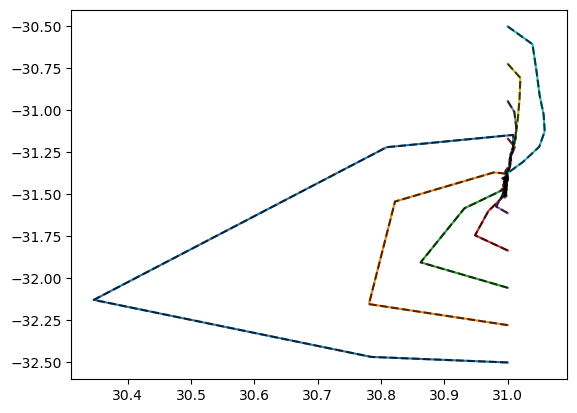

In [6]:
# Plot the resulting particle trajectories overlapped for both cases
advection_then_wind = xr.open_zarr("advection_then_wind.zarr")
wind_then_advection = xr.open_zarr("wind_then_advection.zarr")
plt.plot(wind_then_advection.lon.T, wind_then_advection.lat.T, "-")
plt.plot(advection_then_wind.lon.T, advection_then_wind.lat.T, "--", c="k", alpha=0.7)
plt.show()

## Caveat: Avoid updating particle locations directly in Kernels

It is better not to update `particle.lon` directly in a Kernel, as it can interfere with the loop above. Assigning a value to `particle.lon` in a Kernel will throw a warning. 

Instead, update the local variable `particle.dlon`.

## Working with Status Codes

In order to capture errors in the Kernel loop, Parcels uses a Status Code system. There are several Status Codes, listed below.

In [7]:
from parcels import StatusCode

for statuscode, val in StatusCode.__dict__.items():
    if statuscode.startswith("__"):
        continue
    print(f"{statuscode} = {val}")

Success = 0
EndofLoop = 1
Evaluate = 10
Repeat = 20
Delete = 30
StopExecution = 40
StopAllExecution = 41
Error = 50
ErrorInterpolation = 51
ErrorGridSearching = 52
ErrorOutOfBounds = 60
ErrorThroughSurface = 61
ErrorOutsideTimeInterval = 70


Once an error is thrown (for example, a Field Interpolation error), then the `particle.state` is updated to the corresponding status code. This gives you the flexibility to write a Kernel that checks for a status code and does something with it. 

For example, you can write a Kernel that checks for `particle.state == StatusCode.ErrorOutOfBounds` and deletes the particle, and then append this to the Kernel list in `pset.execute()`.

In [8]:
def CheckOutOfBounds(particles, fieldset):
    if particles.state == StatusCode.ErrorOutOfBounds:
        particles.delete()


def CheckError(particles, fieldset):
    if particles.state >= 50:  # This captures all Errors
        particles.delete()

But of course, you can also write code for more sophisticated behaviour than just deleting the particle. It's up to you! Note that if you don't delete the particle, you will have to update the `particle.state = StatusCode.Success` yourself. For example:

In [9]:
def Move1DegreeWest(particles, fieldset):
    if particles.state == StatusCode.ErrorOutOfBounds:
        particles.dlon -= 1.0
        particles.state = StatusCode.Success

Or, if you want to make sure that particles don't escape through the water surface

In [10]:
def KeepInOcean(particles, fieldset):
    if particles.state == StatusCode.ErrorThroughSurface:
        particles.dz = 0.0
        particles.state = StatusCode.Success

Kernel functions such as the ones above can then be added to the list of kernels in `pset.execute()`. 

Note that these Kernels that control what to do with `particle.state` should typically be added at the _end_ of the Kernel list, because otherwise later Kernels may overwrite the `particle.state` or the `particle_dlon` variables.